# Change detection and raster vectorization

1. Clip rasters / problem of extent.
2. Calculate NDVI.
3. Divide raster into quadrants / problem of scale.
4. Monitor NDVI changes in each quadrant (time series).
5. Locate time with abrupt changes in NDVI value.
6. Check quadrant neighbours then check values pixel by pixel.
7. Clip AoI / AoI statistics.
8. Vectorize AoI.
9. Monitor AoI.

In [7]:
%matplotlib notebook
import numpy as np
import rasterio as rio
import fiona as fio
from fiona.crs import from_epsg
import matplotlib.pyplot as plt

In [2]:
def show_band(band, color_map='gray', remove_negative=True):
    matrix = band.astype(float)
    if remove_negative:
        matrix[matrix <= 0] = np.nan
    fig = plt.figure(figsize=(8,8))
    image_layer = plt.imshow(matrix)
    image_layer.set_cmap(color_map)
    plt.colorbar()
    plt.show()

<IPython.core.display.Javascript object>


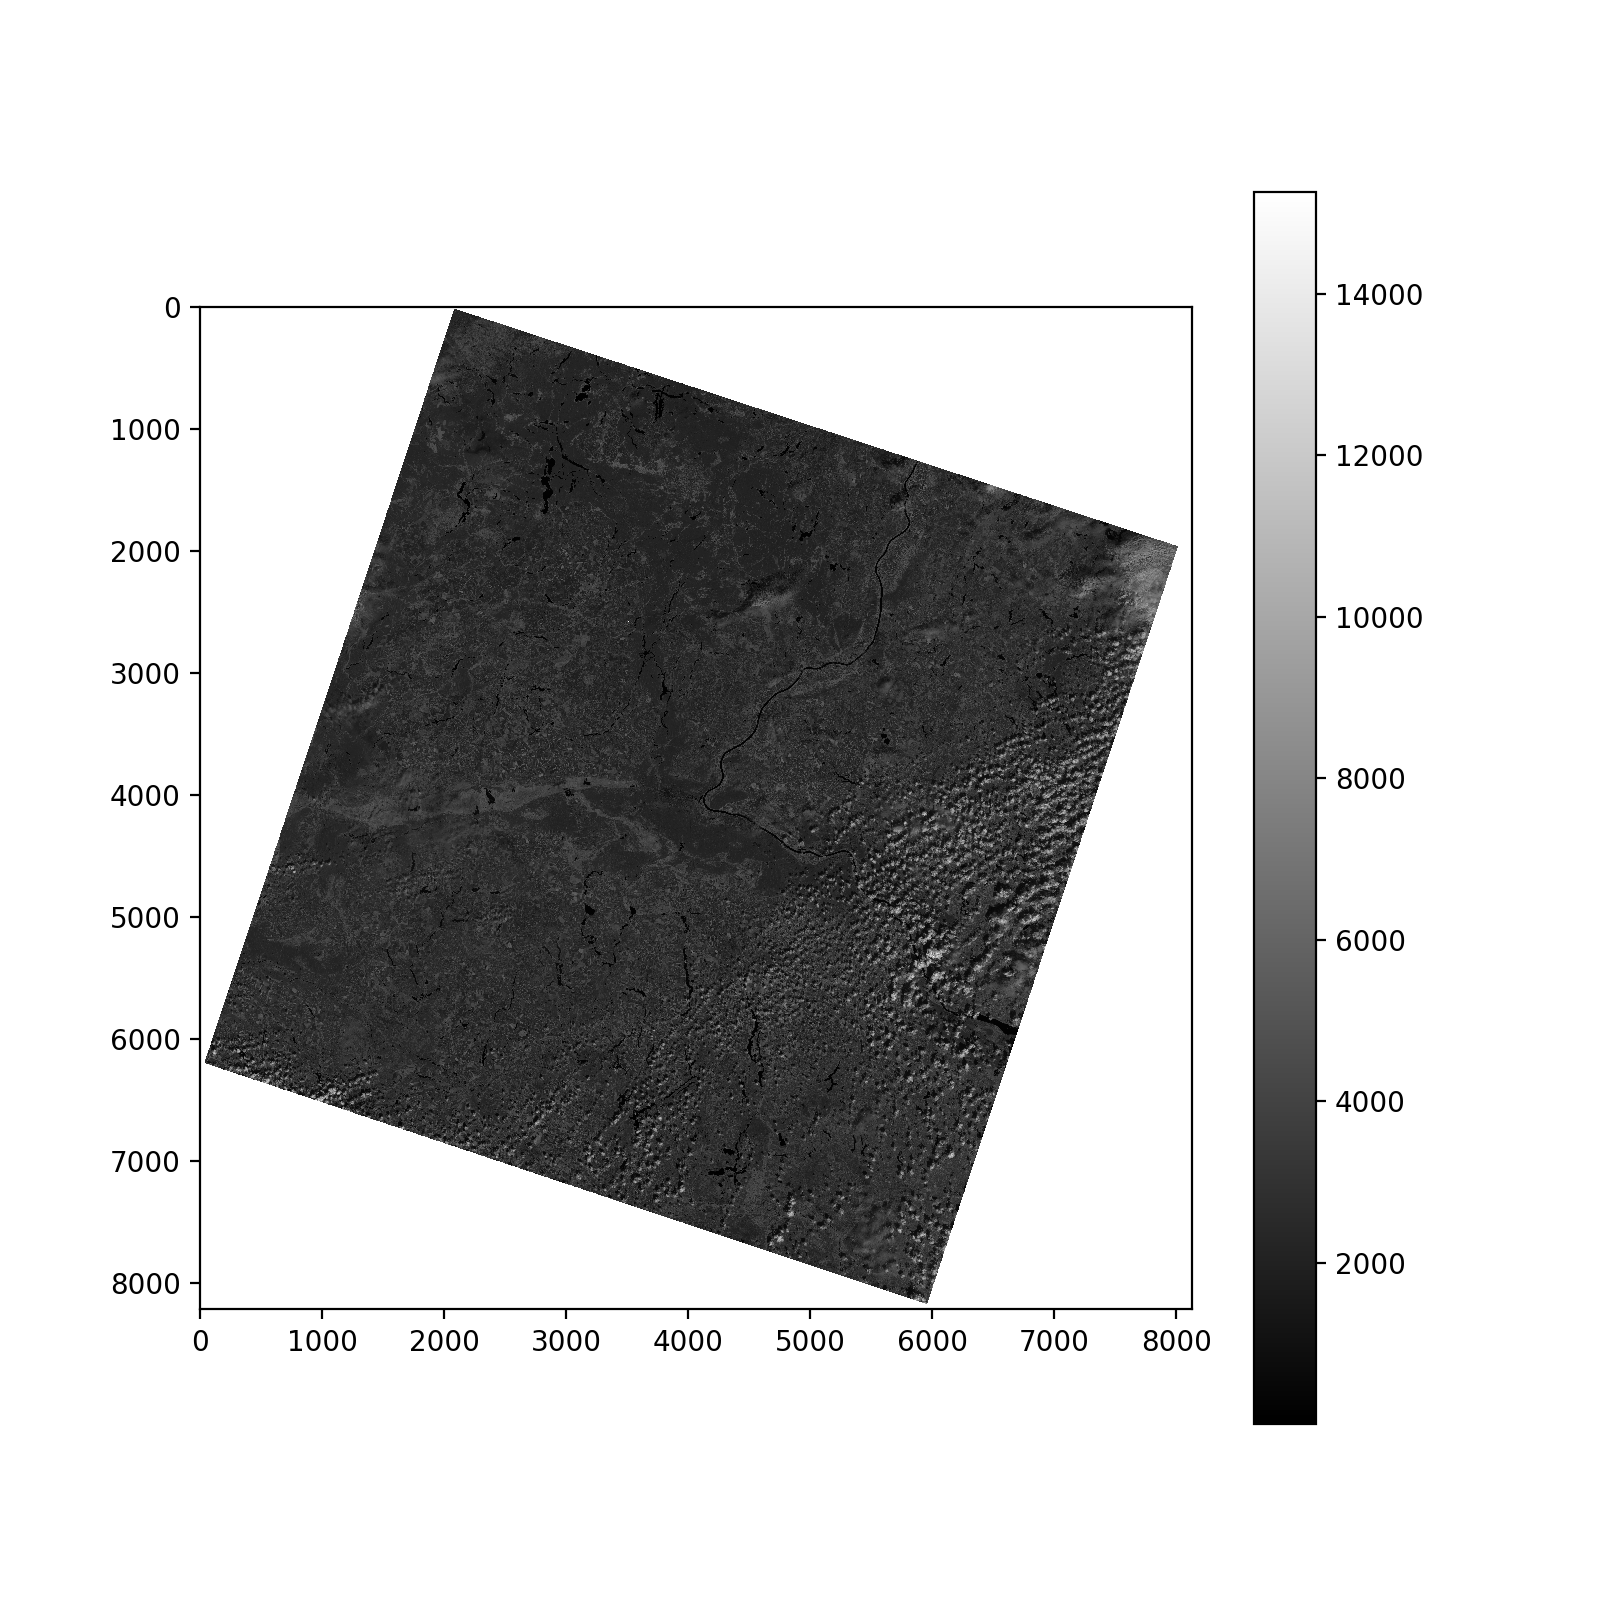

In [3]:
# Read raster data and get crs

with rio.open('data/LC081900232013080501T1-SC20180517172727/LC08_L1TP_190023_20130805_20170503_01_T1_sr_band5.tif') as f:
    band = f.read(1)
    band_crs = f.crs
    
show_band(band)

In [9]:
print('Band coordinate reference system is: {} \nBand WKT: {}'.format(
    band_crs,
    band_crs.wkt))

Band coordinate reference system is: CRS({'init': 'epsg:32634'}) 
Band WKT: PROJCS["WGS 84 / UTM zone 34N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",21],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32634"]]


In [53]:
# Vector - show and get crs
vector_file = 'data/powiat_chojnicki.shp'
with fio.open(vector_file, 'r') as masking_region:
    geometry = [feature["geometry"] for feature in masking_region]
    properties = [feature['properties'] for feature in masking_region]
    mask_crs = masking_region.crs
    mask_schema = masking_region.schema

In [54]:
coordinates_list = geometry[0]['coordinates'][0] # check different cases
coordinates_array = np.asarray(coordinates_list)

<IPython.core.display.Javascript object>


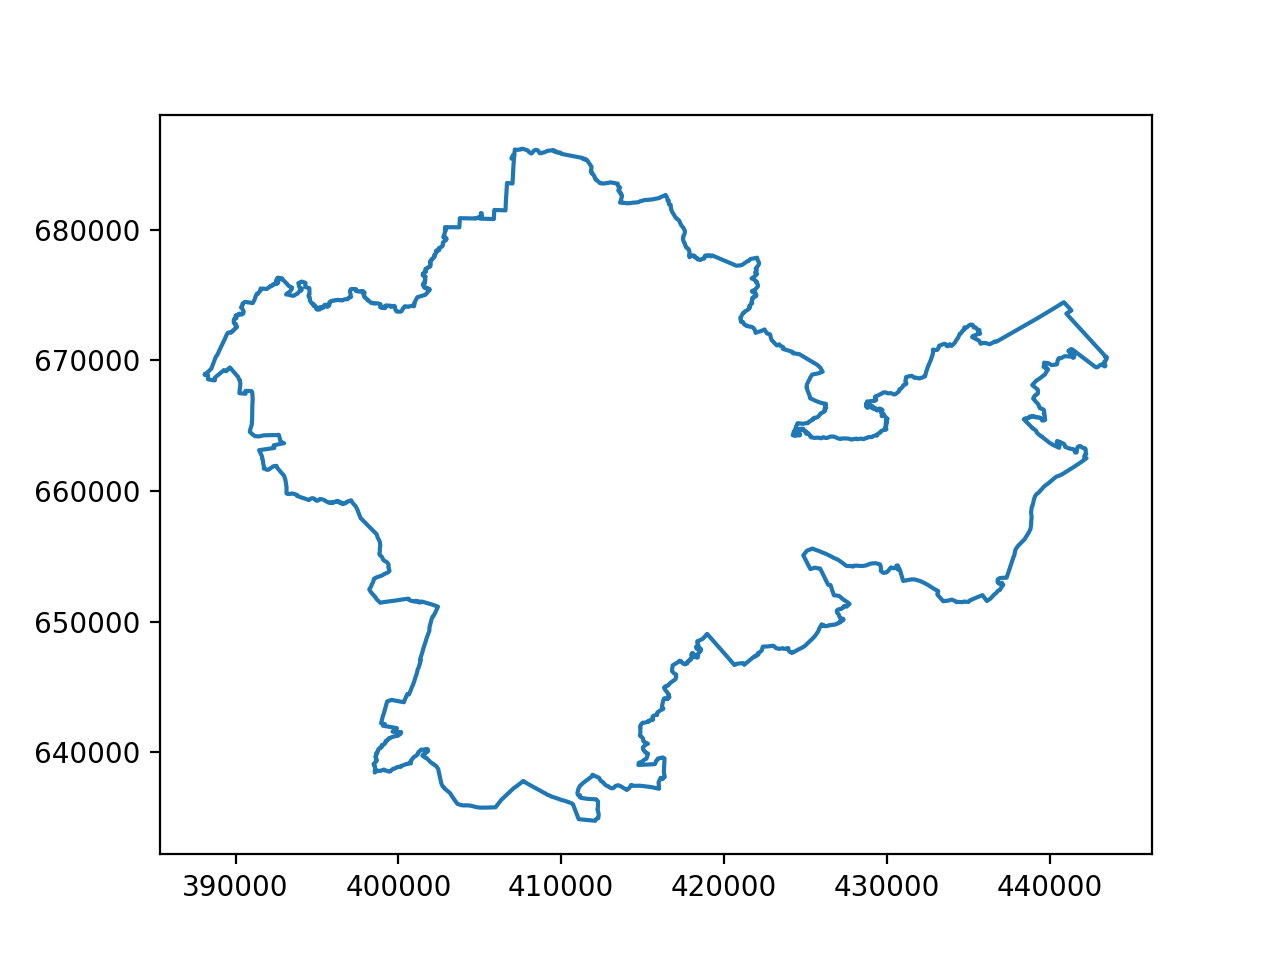

In [55]:
plt.figure()
plt.plot(coordinates_array[:, 0], coordinates_array[:, 1])
plt.show()

In [14]:
# Reprojekcja wektora

destination_epsg = band_crs['init'][5:]
destination_epsg = int(destination_epsg)
destination_crs = from_epsg(destination_epsg)

In [57]:
destination_crs
properties

[OrderedDict([('NAME_PL', 'chojnicki'), ('ID', 1106)])]

In [59]:
powiat_chojnicki = {}
powiat_chojnicki['geometry'] = geometry[0]  # Points need reprojection
powiat_chojnicki['properties'] = properties[0]
mask_schema

{'geometry': 'Polygon',
 'properties': OrderedDict([('NAME_PL', 'str:254'), ('ID', 'int:10')])}

In [60]:
destination_schema = mask_schema

In [61]:
destination_driver = 'ESRI Shapefile'

In [62]:
with fio.open(
    'new.shp',
    'w',
    driver = destination_driver,
    crs = destination_crs,
    schema = destination_schema) as output:
    output.write(powiat_chojnicki)

In [63]:
vector_file = 'new.shp'
with fio.open(vector_file, 'r') as masking_region:
    geometry = [feature["geometry"] for feature in masking_region]

In [64]:
coordinates_list = geometry[0]['coordinates'][0] # check different cases
coordinates_array = np.asarray(coordinates_list)

<IPython.core.display.Javascript object>


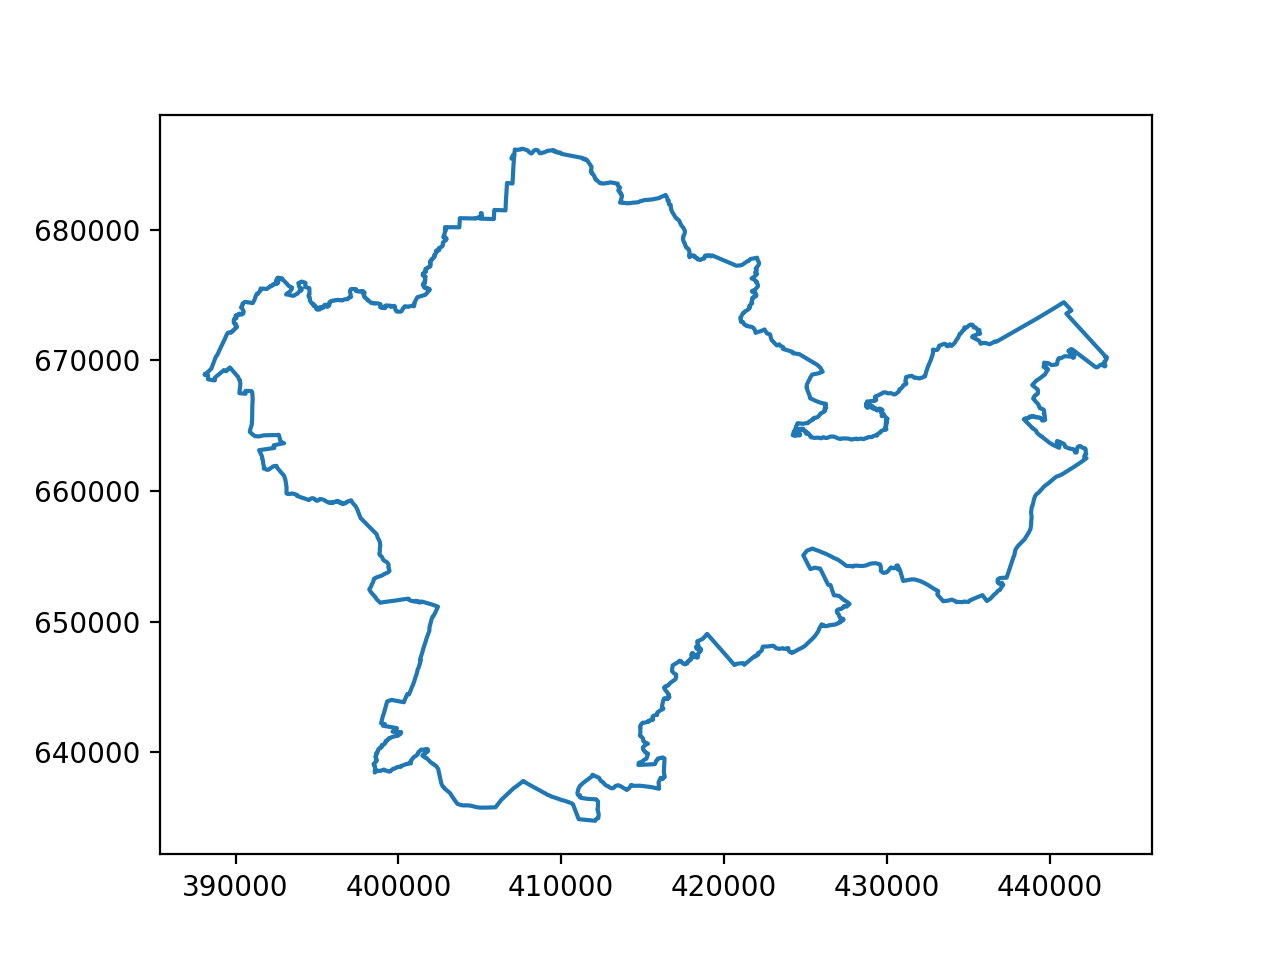

In [65]:
plt.figure()
plt.plot(coordinates_array[:, 0], coordinates_array[:, 1])
plt.show()